In [153]:
import pandas as pd
import numpy as np
import pymysql
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt 
import re
import os
from functools import reduce
pd.options.mode.chained_assignment = None  # default='warn'

## 香蕉交易量排行榜
根據交易資料統計，台中交易市場為最大，因此選擇以台中為主要分析資料，氣候測站選擇南投 => **尚未驗證**
- 2011~2019累計成交量

<img src='image/banana transaction ranking.png'>

In [81]:
username = 'yuting'
password = 'yuting'
host_port = '35.194.136.165:3306' 
database = 'twfruits'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [82]:
fruit = "banana"
market = "台中市"
df_test = pd.read_sql(f"{fruit}_{market}", engine)
df_test.tail()

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
3868,2021-08-04,30.9,23041.0,30.8,19.7,30.3,30.1
3869,2021-08-05,31.8,22484.0,25.6,18.1,30.9,30.8
3870,2021-08-06,30.4,28395.0,32.7,19.4,31.8,30.8
3871,2021-08-07,31.9,20433.0,24.0,20.6,30.4,31.1
3872,2021-08-08,35.2,20832.0,27.0,23.3,31.9,32.0


In [83]:
len(df_test)

3873

In [89]:
df_test = df_test.set_index("日期")

## 交易資料 => 使用台中市場

In [92]:
df_price = pd.read_csv("cleaned data/價格_全國香蕉交易資料(初步清洗).csv", usecols=[0, 1, 2, 3, 4, 5, 6, 8])
df_price.head()

,日期,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
0,2011-01-01,104 台北二,A1 香蕉,35.0,32.1,25.6,31.4,9645
1,2011-01-02,104 台北二,A1 香蕉,35.1,33.1,25.8,32.0,12230
2,2011-01-04,104 台北二,A1 香蕉,35.8,33.1,27.0,32.4,11976
3,2011-01-05,104 台北二,A1 香蕉,36.5,33.9,27.8,33.2,7520
4,2011-01-06,104 台北二,A1 香蕉,38.2,35.5,28.9,34.7,8160


In [93]:
## 只留下台中市場資料
df_price_taichung = df_price.loc[df_price["市場"] == "400 台中市"]

In [94]:
df_price_taichung["日期"] = pd.to_datetime(df_price_taichung["日期"])
df_price_taichung.set_index("日期", inplace=True)

In [95]:
df_price_taichung

,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
日期,,,,,,,
2011-01-01,400 台中市,A1 香蕉,29.4,22.9,12.9,22.1,23713
2011-01-02,400 台中市,A1 香蕉,27.1,22.4,14.3,21.7,27072
2011-01-04,400 台中市,A1 香蕉,29.6,22.9,14.6,24.9,67785
2011-01-05,400 台中市,A1 香蕉,27.3,22.3,16.0,23.6,34038
2011-01-06,400 台中市,A1 香蕉,29.2,22.6,12.4,24.5,18480
...,...,...,...,...,...,...,...
2021-06-10,400 台中市,A1 香蕉,25.8,23.2,13.8,23.1,30348
2021-06-11,400 台中市,A1 香蕉,26.0,23.8,17.0,23.7,20520
2021-06-12,400 台中市,A1 香蕉,26.2,18.6,11.9,22.7,28971


### 補上休市資料
- 目前使用ffill（補前值），這方法不太好，雖補齊休假日空缺，但是否影響資料整體尚待評估 => 使用resample("D")，以日為單位重採集資料

In [96]:
df_price_taichung = df_price_taichung.resample("D").interpolate().fillna(method="ffill")
df_price_taichung

,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
日期,,,,,,,
2011-01-01,400 台中市,A1 香蕉,29.40,22.90,12.90,22.1,23713.0
2011-01-02,400 台中市,A1 香蕉,27.10,22.40,14.30,21.7,27072.0
2011-01-03,400 台中市,A1 香蕉,28.35,22.65,14.45,23.3,47428.5
2011-01-04,400 台中市,A1 香蕉,29.60,22.90,14.60,24.9,67785.0
2011-01-05,400 台中市,A1 香蕉,27.30,22.30,16.00,23.6,34038.0
...,...,...,...,...,...,...,...
2021-06-10,400 台中市,A1 香蕉,25.80,23.20,13.80,23.1,30348.0
2021-06-11,400 台中市,A1 香蕉,26.00,23.80,17.00,23.7,20520.0
2021-06-12,400 台中市,A1 香蕉,26.20,18.60,11.90,22.7,28971.0


### merge


In [100]:
df_output = pd.merge(df_price_taichung, df_test, left_index=True, right_index=True, how="left")
df_output.tail()

,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤),banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
日期,,,,,,,,,,,,,
2021-06-10,400 台中市,A1 香蕉,25.8,23.2,13.8,23.1,30348.0,23.1,30348.0,28.7,32.6,23.2,22.5
2021-06-11,400 台中市,A1 香蕉,26.0,23.8,17.0,23.7,20520.0,23.7,20520.0,31.5,27.6,23.1,22.6
2021-06-12,400 台中市,A1 香蕉,26.2,18.6,11.9,22.7,28971.0,22.7,28971.0,30.1,25.3,23.7,22.7
2021-06-13,400 台中市,A1 香蕉,27.5,23.0,15.0,23.7,20250.0,23.7,20250.0,31.3,20.8,22.7,23.3
2021-06-14,400 台中市,A1 香蕉,28.8,24.1,16.8,25.0,11775.0,25.0,11775.0,26.1,21.9,23.7,23.6


In [102]:
df_output.drop(columns=["banana_平均價", "banana_交易量"], inplace=True)

In [103]:
df_output.columns

Index(['市場', '產品', '上價', '中價', '下價', '平均價(元/公斤)', '交易量(公斤)',
       'scarletbanana_平均價', 'guava_平均價', 'banana_前日平均價', 'banana_5日平均價'],
      dtype='object')

In [104]:
# 改成英文欄位以利後續使用
eng_cols_name = ["Market", "Product", "High price", "Mid price", "Low price", "Average price", "Volume(kg)", 
                 'scarletbanana_Avg_p', 'guava_Avg_p', 'banana_Avg_p(-1d)', 'banana_Avg_p(5d)']
df_output.columns = eng_cols_name

In [105]:
df_output

,Market,Product,High price,Mid price,Low price,Average price,Volume(kg),scarletbanana_Avg_p,guava_Avg_p,banana_Avg_p(-1d),banana_Avg_p(5d)
日期,,,,,,,,,,,
2011-01-01,400 台中市,A1 香蕉,29.40,22.90,12.90,22.1,23713.0,29.7,33.7,22.1,23.1
2011-01-02,400 台中市,A1 香蕉,27.10,22.40,14.30,21.7,27072.0,27.5,36.1,22.1,23.1
2011-01-03,400 台中市,A1 香蕉,28.35,22.65,14.45,23.3,47428.5,32.3,36.1,21.7,23.1
2011-01-04,400 台中市,A1 香蕉,29.60,22.90,14.60,24.9,67785.0,37.1,36.1,23.3,23.1
2011-01-05,400 台中市,A1 香蕉,27.30,22.30,16.00,23.6,34038.0,41.2,35.6,24.9,23.1
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10,400 台中市,A1 香蕉,25.80,23.20,13.80,23.1,30348.0,28.7,32.6,23.2,22.5
2021-06-11,400 台中市,A1 香蕉,26.00,23.80,17.00,23.7,20520.0,31.5,27.6,23.1,22.6
2021-06-12,400 台中市,A1 香蕉,26.20,18.60,11.90,22.7,28971.0,30.1,25.3,23.7,22.7


### 新增欄位需求
- 移動平均（5日均價）

## 天氣資料 => 使用日月潭測站資料

### 主要欄位中文名稱

<img src='image/weather_columns(definition).png' width=1600>

### 異常值符號代表意義&處理方式

In [12]:
dict_symbol = {"Symbol":["T", "x", "&", "V", "/", "..."],
               "Explanation":["微量(小於 0.1mm)", "故障", "降水量資料累積於後", "風向不定", "不明", "無觀測"],
               "Replacement":[0.0, "ffill", "ffill", "ffill", "ffill", "ffill"]
              }
df_symbol = pd.DataFrame(dict_symbol)
df_symbol

,Symbol,Explanation,Replacement
0,T,微量(小於 0.1mm),0
1,x,故障,ffill
2,&,降水量資料累積於後,ffill
3,V,風向不定,ffill
4,/,不明,ffill
5,...,無觀測,ffill


### 中英欄位對照表

In [34]:
col_data = "觀測時間(LST)ObsTime、測站氣壓(hPa)StnPres、海平面氣壓(hPa)SeaPres、測站最高氣壓(hPa)StnPresMax、測站最高氣壓時間(LST)StnPresMaxTime、測站最低氣壓(hPa)StnPresMin、測站最低氣壓時間(LST)StnPresMinTime、氣溫(℃)Temperature、最高氣溫(℃)T Max、最高氣溫時間(LST)T Max Time、最低氣溫(℃)T Min、最低氣溫時間(LST)T Min Time、露點溫度(℃)Td dew point、相對溼度(%)RH、最小相對溼度(%)RHMin、最小相對溼度時間(LST)RHMinTime、風速(m/s)WS、風向(360degree)WD、最大陣風(m/s)WSGust、最大陣風風向(360degree)WDGust、最大陣風風速時間(LST)WGustTime、降水量(mm)Precp、降水時數(hr)PrecpHour、10分鐘最大降水量(mm)PrecpMax10、10分鐘最大降水起始時間(LST)PrecpMax10Time、一小時最大降水量(mm)PrecpHrMax、一小時最大降水量起始時間(LST)PrecpHrMaxTime、日照時數(hr)SunShine、日照率(%)SunShineRate、全天空日射量(MJ/㎡)GloblRad、能見度(km)VisbMean、A型蒸發量(mm)EvapA"
datas = [i for i in col_data.split("、")]
chi,eng =[],[]
for data in datas:
    chi.append(data.split(")")[0]+")")
    eng.append(data.split(")")[1])
df_columns_name = pd.DataFrame({"英文名稱":eng, 
                                "中文名稱":chi})
df_columns_name


,英文名稱,中文名稱
0,ObsTime,觀測時間(LST)
1,StnPres,測站氣壓(hPa)
2,SeaPres,海平面氣壓(hPa)
3,StnPresMax,測站最高氣壓(hPa)
4,StnPresMaxTime,測站最高氣壓時間(LST)
5,StnPresMin,測站最低氣壓(hPa)
6,StnPresMinTime,測站最低氣壓時間(LST)
7,Temperature,氣溫(℃)
8,T Max,最高氣溫(℃)
9,T Max Time,最高氣溫時間(LST)


In [106]:
df_weather_taichung = pd.read_csv("cleaned data/weather_data/日月潭.csv")
df_weather_taichung

,ObsTime,StnPres,SeaPres,StnPresMax,StnPresMaxTime,StnPresMin,StnPresMinTime,Temperature,T Max,T Max Time,...,PrecpMax60,PrecpMax60Time,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,UVI Max Time,Cloud Amount
0,1,904.3,1530.8,905.3,2010-01-01 09:24,903.3,2010-01-01 14:12,13.4,16.3,2010-01-01 14:29,...,0.0,...,0.1,0.9,4.63,20.0,0.9,2,2010-01-01 11:00,9.5
1,2,903.1,1522.7,904.8,2010-01-02 00:04,901.7,2010-01-02 14:32,14.6,17.6,2010-01-02 11:09,...,0.7,2010-01-02 20:35,1.1,10.3,5.22,20.9,-0.5,2,2010-01-02 12:00,9.2
2,3,902.5,1513.9,904.1,2010-01-03 08:05,900.8,2010-01-03 14:29,12.6,18.1,2010-01-03 13:21,...,6.0,2010-01-03 04:29,4.2,39.4,9.23,14.2,-0.9,5,2010-01-03 13:00,8.4
3,4,902.3,1512.9,903.5,2010-01-04 09:31,900.9,2010-01-04 14:15,13.8,19.7,2010-01-04 13:38,...,0.0,...,8.1,76.0,14.42,19.7,0.6,5,2010-01-04 13:00,3.8
4,5,902.8,1518.9,904.8,2010-01-05 09:14,901.3,2010-01-05 13:47,13.7,19.3,2010-01-05 13:27,...,0.0,...,1.5,14.1,7.78,18.2,-0.7,3,2010-01-05 13:00,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,26,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,27,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,28,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4197,29,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [107]:
df_weather_taichung.dtypes

ObsTime            int64
StnPres           object
SeaPres           object
StnPresMax        object
StnPresMaxTime    object
StnPresMin        object
StnPresMinTime    object
Temperature       object
T Max             object
T Max Time        object
T Min             object
T Min Time        object
Td dew point      object
RH                object
RHMin             object
RHMinTime         object
WS                object
WD                object
WSGust            object
WDGust            object
WGustTime         object
Precp             object
PrecpHour         object
PrecpMax10        object
PrecpMax10Time    object
PrecpMax60        object
PrecpMax60Time    object
SunShine          object
SunShineRate      object
GloblRad          object
VisbMean          object
EvapA             object
UVI Max           object
UVI Max Time      object
Cloud Amount      object
dtype: object

In [108]:
# 為後續資料清洗，從df_weather_taichungd拷貝一份當成df_test，避免改動到原檔案導致重新讀取
# 刪除ObsTime欄位
df_test = df_weather_taichung.copy()
df_test.drop(columns="ObsTime", inplace=True)

In [109]:
df_test

,StnPres,SeaPres,StnPresMax,StnPresMaxTime,StnPresMin,StnPresMinTime,Temperature,T Max,T Max Time,T Min,...,PrecpMax60,PrecpMax60Time,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,UVI Max Time,Cloud Amount
0,904.3,1530.8,905.3,2010-01-01 09:24,903.3,2010-01-01 14:12,13.4,16.3,2010-01-01 14:29,11.1,...,0.0,...,0.1,0.9,4.63,20.0,0.9,2,2010-01-01 11:00,9.5
1,903.1,1522.7,904.8,2010-01-02 00:04,901.7,2010-01-02 14:32,14.6,17.6,2010-01-02 11:09,12.6,...,0.7,2010-01-02 20:35,1.1,10.3,5.22,20.9,-0.5,2,2010-01-02 12:00,9.2
2,902.5,1513.9,904.1,2010-01-03 08:05,900.8,2010-01-03 14:29,12.6,18.1,2010-01-03 13:21,10.4,...,6.0,2010-01-03 04:29,4.2,39.4,9.23,14.2,-0.9,5,2010-01-03 13:00,8.4
3,902.3,1512.9,903.5,2010-01-04 09:31,900.9,2010-01-04 14:15,13.8,19.7,2010-01-04 13:38,9.8,...,0.0,...,8.1,76.0,14.42,19.7,0.6,5,2010-01-04 13:00,3.8
4,902.8,1518.9,904.8,2010-01-05 09:14,901.3,2010-01-05 13:47,13.7,19.3,2010-01-05 13:27,10.8,...,0.0,...,1.5,14.1,7.78,18.2,-0.7,3,2010-01-05 13:00,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4197,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [110]:
# 去除 \xa0 = space
df_test = df_test.applymap(lambda x: x.replace("\xa0",""))

In [111]:
# 將"..."取代為np.nan
df_test = df_test.replace("...", np.nan)

In [112]:
# dropna => 刪除欄位全部為null的row
df_test.dropna(how="all", inplace=True)
df_test.tail()

,StnPres,SeaPres,StnPresMax,StnPresMaxTime,StnPresMin,StnPresMinTime,Temperature,T Max,T Max Time,T Min,...,PrecpMax60,PrecpMax60Time,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,UVI Max Time,Cloud Amount
4178,898.6,1493.7,900.4,2021-06-10 00:03,896.5,2021-06-10 16:00,22.4,28.5,2021-06-10 13:55,19.1,...,6.0,2021-06-10 00:01,4.4,32.5,16.21,22.5,-2.8,8,2021-06-10 14:00,7.2
4179,899.3,1502.2,901.8,2021-06-11 21:31,897.9,2021-06-11 07:02,23.2,28.6,2021-06-11 12:54,19.6,...,0.5,2021-06-11 19:59,3.8,28.1,16.23,25.5,-2.0,9,2021-06-11 13:00,7.5
4180,901.7,1524.9,903.6,2021-06-12 22:07,900.5,2021-06-12 16:20,22.5,28.9,2021-06-12 12:34,19.4,...,14.5,2021-06-12 16:06,2.8,20.7,14.51,7.5,-3.1,9,2021-06-12 13:00,7.8
4181,901.4,1522.1,903.1,2021-06-13 00:01,898.8,2021-06-13 16:51,23.1,29.4,2021-06-13 12:57,20.1,...,11.5,2021-06-13 17:03,4.9,35.4,20.10,22.5,-3.9,9,2021-06-13 13:00,6.2
4182,898.8,1498.2,901.2,2021-06-14 00:05,897.3,2021-06-14 16:57,23.5,29.0,2021-06-14 13:10,20.4,...,0.0,NaN,6.3,46.5,22.43,25.8,4.2,10,2021-06-14 12:00,5.8


In [113]:
# 新增欄位「日期」，做為稍後合併兩個dataframe的鍵值
df_test["日期"] =  df_test["StnPresMaxTime"].apply(lambda x: x[:10])
df_test

,StnPres,SeaPres,StnPresMax,StnPresMaxTime,StnPresMin,StnPresMinTime,Temperature,T Max,T Max Time,T Min,...,PrecpMax60Time,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,UVI Max Time,Cloud Amount,日期
0,904.3,1530.8,905.3,2010-01-01 09:24,903.3,2010-01-01 14:12,13.4,16.3,2010-01-01 14:29,11.1,...,NaN,0.1,0.9,4.63,20.0,0.9,2,2010-01-01 11:00,9.5,2010-01-01
1,903.1,1522.7,904.8,2010-01-02 00:04,901.7,2010-01-02 14:32,14.6,17.6,2010-01-02 11:09,12.6,...,2010-01-02 20:35,1.1,10.3,5.22,20.9,-0.5,2,2010-01-02 12:00,9.2,2010-01-02
2,902.5,1513.9,904.1,2010-01-03 08:05,900.8,2010-01-03 14:29,12.6,18.1,2010-01-03 13:21,10.4,...,2010-01-03 04:29,4.2,39.4,9.23,14.2,-0.9,5,2010-01-03 13:00,8.4,2010-01-03
3,902.3,1512.9,903.5,2010-01-04 09:31,900.9,2010-01-04 14:15,13.8,19.7,2010-01-04 13:38,9.8,...,NaN,8.1,76.0,14.42,19.7,0.6,5,2010-01-04 13:00,3.8,2010-01-04
4,902.8,1518.9,904.8,2010-01-05 09:14,901.3,2010-01-05 13:47,13.7,19.3,2010-01-05 13:27,10.8,...,NaN,1.5,14.1,7.78,18.2,-0.7,3,2010-01-05 13:00,7.0,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,898.6,1493.7,900.4,2021-06-10 00:03,896.5,2021-06-10 16:00,22.4,28.5,2021-06-10 13:55,19.1,...,2021-06-10 00:01,4.4,32.5,16.21,22.5,-2.8,8,2021-06-10 14:00,7.2,2021-06-10
4179,899.3,1502.2,901.8,2021-06-11 21:31,897.9,2021-06-11 07:02,23.2,28.6,2021-06-11 12:54,19.6,...,2021-06-11 19:59,3.8,28.1,16.23,25.5,-2.0,9,2021-06-11 13:00,7.5,2021-06-11
4180,901.7,1524.9,903.6,2021-06-12 22:07,900.5,2021-06-12 16:20,22.5,28.9,2021-06-12 12:34,19.4,...,2021-06-12 16:06,2.8,20.7,14.51,7.5,-3.1,9,2021-06-12 13:00,7.8,2021-06-12
4181,901.4,1522.1,903.1,2021-06-13 00:01,898.8,2021-06-13 16:51,23.1,29.4,2021-06-13 12:57,20.1,...,2021-06-13 17:03,4.9,35.4,20.10,22.5,-3.9,9,2021-06-13 13:00,6.2,2021-06-13


In [114]:
# 刪除幾個不必要的時間欄位
df_columns = list(df_test.columns)
time_cols = list(filter(lambda x : re.findall(".*Time", x), df_columns))

In [115]:
time_cols

['StnPresMaxTime',
 'StnPresMinTime',
 'T Max Time',
 'T Min Time',
 'RHMinTime',
 'WGustTime',
 'PrecpMax10Time',
 'PrecpMax60Time',
 'UVI Max Time']

In [116]:
df_test.drop(columns=time_cols, inplace=True)

### 找出無法轉換資料型態的欄位，並對其進行處理

In [117]:
# transform to numeric type => 準備fail_col來存放失敗欄位，稍後處理
fail_col = []
for col in list(df_test.columns):
    try:
        df_test[col] = df_test[col].apply(pd.to_numeric)
    except:
        print(f"{col}:轉換失敗")
        fail_col.append(col)

Precp:轉換失敗
PrecpMax10:轉換失敗
PrecpMax60:轉換失敗
GloblRad:轉換失敗
EvapA:轉換失敗
UVI Max:轉換失敗
Cloud Amount:轉換失敗
日期:轉換失敗


In [118]:
df_test["WD"].sum()

1000160

In [121]:
# WD (wind direction)
# 將缺值（Ｘ）取代成眾數
# df_test.loc[~(df_test["WD"].str.isnumeric()), "WD"] = df_test["WD"].mode()[0]

In [122]:
# WSGust(最大陣風)
# unique()找出後解決
# 問題 => 如何快速找到不為float的欄位（isnumeric無效）

df_test["WSGust"].unique()
df_test.loc[(df_test["WSGust"] == "X"), "WSGust"] = np.nan
df_test["WSGust"].fillna(method="ffill", inplace=True)

In [32]:
# WDGust(最大陣風方向)
#df_test.loc[~(df_test["WDGust"].str.isnumeric()), "WDGust"] = df_test["WDGust"].mode()[0]


In [123]:
# Precp(降水量)
# 無雨時 => T 
# bad_data = list(filter(lambda x :re.match("[^(\d\.\d)]", x), list(df_test["Precp"])))

df_test.loc[(df_test["Precp"] == "T")]
df_test.loc[df_test["PrecpMax10"] == "T", "PrecpMax10"] = 0.0
df_test.loc[(df_test["Precp"] == "T"), ["Precp", "PrecpMax10", "PrecpMax60"]] = 0.0

In [124]:
# EvapA (A型蒸發量)
df_test.loc[(df_test["EvapA"] == "/"), "EvapA"] = np.nan
df_test["EvapA"].fillna(method="ffill", inplace=True)

In [125]:
df_test.loc[df_test["UVI Max"] == "X"]

,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,Td dew point,RH,RHMin,...,PrecpMax10,PrecpMax60,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,Cloud Amount,日期
591,903.1,1538.7,904.5,902.0,23.4,30.2,20.3,20.4,84,65,...,0.0,0.0,5.7,44.1,15.44,20.3,3.0,X,6.8,2011-08-15
592,902.2,1530.2,903.7,900.8,23.3,30.4,19.7,19.6,80,65,...,0.5,0.5,7.4,57.4,16.51,16.5,-3.0,X,5.7,2011-08-16
593,901.8,1525.8,902.9,900.6,23.4,30.4,19.6,19.0,77,60,...,0.0,0.0,9.5,73.8,21.04,24.2,4.0,X,2.8,2011-08-17
594,902.0,1528.8,903.3,900.7,23.7,30.7,20.1,19.5,78,55,...,6.5,10.5,9.4,73.1,21.55,18.3,-6.1,X,3.7,2011-08-18
595,902.4,1530.5,903.7,901.3,22.8,28.8,18.6,19.6,83,67,...,0.0,0.0,7.5,58.4,18.84,20.8,4.9,X,6.5,2011-08-19
596,902.2,1529.1,903.2,901.2,23.1,30.1,19.3,20.5,85,65,...,0.0,0.0,5.2,40.6,15.01,11.3,3.9,X,6.3,2011-08-20
597,901.3,1520.3,902.6,899.9,22.9,29.7,20.2,20.0,84,65,...,0.0,0.0,4.3,33.6,15.71,8.0,3.4,X,5.0,2011-08-21
598,899.9,1507.1,901.1,898.6,23.1,28.4,20.2,19.8,82,67,...,0.0,0.0,7.1,55.6,19.14,5.0,2.3,X,5.8,2011-08-22
599,898.7,1495.0,900.1,897.2,22.8,28.8,19.9,19.7,83,64,...,0,0,6.5,51.0,14.48,7.3,-2.7,X,5.2,2011-08-23
600,898.4,1491.0,899.4,896.9,21.7,26.8,19.0,19.7,89,74,...,15.5,52.0,2.9,22.8,8.24,6.0,-4.2,X,6.8,2011-08-24


In [126]:
# UVI Max (最大紫外線)
df_test.loc[df_test["UVI Max"] == "X", "UVI Max"] = np.nan
df_test["UVI Max"].fillna(method="ffill", inplace=True)

In [127]:
df_test.iloc[2,:]

StnPres              902.5
SeaPres             1513.9
StnPresMax           904.1
StnPresMin           900.8
Temperature           12.6
T Max                 18.1
T Min                 10.4
Td dew point          11.7
RH                      95
RHMin                   69
WS                     1.7
WD                     290
WSGust                10.2
WDGust                 320
Precp                 18.0
PrecpHour              9.8
PrecpMax10             2.5
PrecpMax60             6.0
SunShine               4.2
SunShineRate          39.4
GloblRad              9.23
VisbMean              14.2
EvapA                 -0.9
UVI Max                  5
Cloud Amount           8.4
日期              2010-01-03
Name: 2, dtype: object

In [128]:
# Clound Amount
df_test.loc[(df_test["Cloud Amount"] == "/"), "Cloud Amount"] = np.nan
df_test["Cloud Amount"].fillna(method="ffill", inplace=True)

In [129]:
# GloblRad 
df_test.loc[(df_test['GloblRad'] == "X"), 'GloblRad'] = np.nan
df_test["GloblRad"].fillna(method="ffill", inplace=True)

### 轉換數值

注意：
- 類別型欄位 => WD、WDGust、WSGust、UVI Max
- 時間序列欄位 => 日期
- 其餘皆數值欄位

In [130]:
df_test.dtypes

StnPres         float64
SeaPres         float64
StnPresMax      float64
StnPresMin      float64
Temperature     float64
T Max           float64
T Min           float64
Td dew point    float64
RH                int64
RHMin             int64
WS              float64
WD                int64
WSGust          float64
WDGust            int64
Precp            object
PrecpHour       float64
PrecpMax10       object
PrecpMax60       object
SunShine        float64
SunShineRate    float64
GloblRad         object
VisbMean        float64
EvapA            object
UVI Max          object
Cloud Amount     object
日期               object
dtype: object

In [63]:
fail_col

['Precp',
 'PrecpMax10',
 'PrecpMax60',
 'GloblRad',
 'EvapA',
 'UVI Max',
 'Cloud Amount',
 '日期']

In [64]:
cols = ["Precp", 'PrecpMax10', 'PrecpMax60','EvapA', "GloblRad","UVI Max", "Cloud Amount"]
df_test[cols] = df_test[cols].apply(pd.to_numeric)

In [65]:
df_test.dtypes

StnPres         float64
SeaPres         float64
StnPresMax      float64
StnPresMin      float64
Temperature     float64
T Max           float64
T Min           float64
Td dew point    float64
RH                int64
RHMin             int64
WS              float64
WD                int64
WSGust          float64
WDGust            int64
Precp           float64
PrecpHour       float64
PrecpMax10      float64
PrecpMax60      float64
SunShine        float64
SunShineRate    float64
GloblRad        float64
VisbMean        float64
EvapA           float64
UVI Max           int64
Cloud Amount    float64
日期               object
dtype: object

### 重新排序欄位

In [131]:
cols = list(df_test.columns)
df_test = df_test[[cols[-1]] + cols[:-1]]

In [132]:
df_test["日期"] = pd.to_datetime(df_test["日期"])

In [133]:
df_test.set_index("日期", drop=True, inplace=True)

In [134]:
# 取代原本的df_weather_taichung
df_weather_taichung = df_test

In [135]:
df_weather_taichung

,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,Td dew point,RH,RHMin,...,PrecpHour,PrecpMax10,PrecpMax60,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,Cloud Amount
日期,,,,,,,,,,,,,,,,,,,,,
2010-01-01,904.3,1530.8,905.3,903.3,13.4,16.3,11.1,11.1,86,68,...,0.0,0.0,0.0,0.1,0.9,4.63,20.0,0.9,2,9.5
2010-01-02,903.1,1522.7,904.8,901.7,14.6,17.6,12.6,11.6,83,68,...,4.9,0.4,0.7,1.1,10.3,5.22,20.9,-0.5,2,9.2
2010-01-03,902.5,1513.9,904.1,900.8,12.6,18.1,10.4,11.7,95,69,...,9.8,2.5,6.0,4.2,39.4,9.23,14.2,-0.9,5,8.4
2010-01-04,902.3,1512.9,903.5,900.9,13.8,19.7,9.8,10.1,80,57,...,0.0,0.0,0.0,8.1,76.0,14.42,19.7,0.6,5,3.8
2010-01-05,902.8,1518.9,904.8,901.3,13.7,19.3,10.8,8.9,74,44,...,0.0,0.0,0.0,1.5,14.1,7.78,18.2,-0.7,3,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10,898.6,1493.7,900.4,896.5,22.4,28.5,19.1,20.5,89,67,...,6.2,2.5,6.0,4.4,32.5,16.21,22.5,-2.8,8,7.2
2021-06-11,899.3,1502.2,901.8,897.9,23.2,28.6,19.6,20.9,88,68,...,0.3,0.5,0.5,3.8,28.1,16.23,25.5,-2.0,9,7.5
2021-06-12,901.7,1524.9,903.6,900.5,22.5,28.9,19.4,21.2,93,65,...,6.2,7.5,14.5,2.8,20.7,14.51,7.5,-3.1,9,7.8


## 使用index以leftjoin方式，合併兩個dataframe

In [136]:
df_merged = df_output.merge(df_weather_taichung, how="left", on="日期")

In [138]:
df_merged[[ "Price change rate", "Volume change rate"]] = df_merged[["Price change rate", "Volume change rate"]].apply(lambda x: round(x, 2))


KeyError: "None of [Index(['Price change rate', 'Volume change rate'], dtype='object')] are in the [columns]"

In [137]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3818 entries, 2011-01-01 to 2021-06-14
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Market               3818 non-null   object 
 1   Product              3818 non-null   object 
 2   High price           3818 non-null   float64
 3   Mid price            3818 non-null   float64
 4   Low price            3818 non-null   float64
 5   Average price        3818 non-null   float64
 6   Volume(kg)           3818 non-null   float64
 7   scarletbanana_Avg_p  3818 non-null   float64
 8   guava_Avg_p          3818 non-null   float64
 9   banana_Avg_p(-1d)    3818 non-null   float64
 10  banana_Avg_p(5d)     3818 non-null   float64
 11  StnPres              3818 non-null   float64
 12  SeaPres              3818 non-null   float64
 13  StnPresMax           3818 non-null   float64
 14  StnPresMin           3818 non-null   float64
 15  Temperature         

In [163]:
df_merged

,Market,Product,High price,Mid price,Low price,Average price,Volume(kg),scarletbanana_Avg_p,guava_Avg_p,banana_Avg_p(-1d),...,PrecpHour,PrecpMax10,PrecpMax60,SunShine,SunShineRate,GloblRad,VisbMean,EvapA,UVI Max,Cloud Amount
日期,,,,,,,,,,,,,,,,,,,,,
2011-01-01,400 台中市,A1 香蕉,29.40,22.90,12.90,22.1,23713.0,29.7,33.7,22.1,...,0.0,0.0,0.0,9.6,90.2,12.96,10.0,1.8,5,1.3
2011-01-02,400 台中市,A1 香蕉,27.10,22.40,14.30,21.7,27072.0,27.5,36.1,22.1,...,0.0,0.0,0.0,9.7,91.1,13.20,10.8,2.0,6,1.7
2011-01-03,400 台中市,A1 香蕉,28.35,22.65,14.45,23.3,47428.5,32.3,36.1,21.7,...,0.0,0.0,0.0,1.1,10.3,3.39,11.0,0.4,3,8.8
2011-01-04,400 台中市,A1 香蕉,29.60,22.90,14.60,24.9,67785.0,37.1,36.1,23.3,...,0.0,0.0,0.0,6.4,60.0,11.96,14.0,-1.4,6,5.8
2011-01-05,400 台中市,A1 香蕉,27.30,22.30,16.00,23.6,34038.0,41.2,35.6,24.9,...,4.4,0.5,0.5,5.1,47.8,10.17,17.0,-1.2,6,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10,400 台中市,A1 香蕉,25.80,23.20,13.80,23.1,30348.0,28.7,32.6,23.2,...,6.2,2.5,6.0,4.4,32.5,16.21,22.5,-2.8,8,7.2
2021-06-11,400 台中市,A1 香蕉,26.00,23.80,17.00,23.7,20520.0,31.5,27.6,23.1,...,0.3,0.5,0.5,3.8,28.1,16.23,25.5,-2.0,9,7.5
2021-06-12,400 台中市,A1 香蕉,26.20,18.60,11.90,22.7,28971.0,30.1,25.3,23.7,...,6.2,7.5,14.5,2.8,20.7,14.51,7.5,-3.1,9,7.8


In [76]:
# 輸出合併檔案
# df_merged.to_csv("analysis data/台中_香蕉合併資料(價格&天氣).csv")

### 相關性分析

In [143]:
df_num = df_merged.select_dtypes(include=["int64", "float64"])
df_num

,High price,Mid price,Low price,Average price,Volume(kg),scarletbanana_Avg_p,guava_Avg_p,banana_Avg_p(-1d),banana_Avg_p(5d),StnPres,...,RH,RHMin,WS,WD,WSGust,WDGust,PrecpHour,SunShine,SunShineRate,VisbMean
日期,,,,,,,,,,,,,,,,,,,,,
2011-01-01,29.40,22.90,12.90,22.1,23713.0,29.7,33.7,22.1,23.1,903.2,...,69,56,1.3,20,5.3,260,0.0,9.6,90.2,10.0
2011-01-02,27.10,22.40,14.30,21.7,27072.0,27.5,36.1,22.1,23.1,905.0,...,71,54,1.2,10,5.4,260,0.0,9.7,91.1,10.8
2011-01-03,28.35,22.65,14.45,23.3,47428.5,32.3,36.1,21.7,23.1,904.4,...,80,69,1.0,330,3.5,210,0.0,1.1,10.3,11.0
2011-01-04,29.60,22.90,14.60,24.9,67785.0,37.1,36.1,23.3,23.1,904.7,...,79,53,1.0,50,3.6,80,0.0,6.4,60.0,14.0
2011-01-05,27.30,22.30,16.00,23.6,34038.0,41.2,35.6,24.9,23.1,904.5,...,79,64,1.5,320,4.8,120,4.4,5.1,47.8,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10,25.80,23.20,13.80,23.1,30348.0,28.7,32.6,23.2,22.5,898.6,...,89,67,1.4,160,8.1,90,6.2,4.4,32.5,22.5
2021-06-11,26.00,23.80,17.00,23.7,20520.0,31.5,27.6,23.1,22.6,899.3,...,88,68,1.0,330,5.1,270,0.3,3.8,28.1,25.5
2021-06-12,26.20,18.60,11.90,22.7,28971.0,30.1,25.3,23.7,22.7,901.7,...,93,65,1.3,80,8.5,200,6.2,2.8,20.7,7.5


In [144]:
# 變換欄位順序 => 把average price拉出來放在最後一欄
col_target = list(df_num["Average price"])
df_num.drop(columns="Average price", inplace=True)
df_num.insert(26, "Average price", col_target)

In [145]:
df_num

,High price,Mid price,Low price,Volume(kg),scarletbanana_Avg_p,guava_Avg_p,banana_Avg_p(-1d),banana_Avg_p(5d),StnPres,SeaPres,...,RHMin,WS,WD,WSGust,WDGust,PrecpHour,SunShine,SunShineRate,VisbMean,Average price
日期,,,,,,,,,,,,,,,,,,,,,
2011-01-01,29.40,22.90,12.90,23713.0,29.7,33.7,22.1,23.1,903.2,1517.6,...,56,1.3,20,5.3,260,0.0,9.6,90.2,10.0,22.1
2011-01-02,27.10,22.40,14.30,27072.0,27.5,36.1,22.1,23.1,905.0,1533.4,...,54,1.2,10,5.4,260,0.0,9.7,91.1,10.8,21.7
2011-01-03,28.35,22.65,14.45,47428.5,32.3,36.1,21.7,23.1,904.4,1528.6,...,69,1.0,330,3.5,210,0.0,1.1,10.3,11.0,23.3
2011-01-04,29.60,22.90,14.60,67785.0,37.1,36.1,23.3,23.1,904.7,1532.7,...,53,1.0,50,3.6,80,0.0,6.4,60.0,14.0,24.9
2011-01-05,27.30,22.30,16.00,34038.0,41.2,35.6,24.9,23.1,904.5,1535.5,...,64,1.5,320,4.8,120,4.4,5.1,47.8,17.0,23.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10,25.80,23.20,13.80,30348.0,28.7,32.6,23.2,22.5,898.6,1493.7,...,67,1.4,160,8.1,90,6.2,4.4,32.5,22.5,23.1
2021-06-11,26.00,23.80,17.00,20520.0,31.5,27.6,23.1,22.6,899.3,1502.2,...,68,1.0,330,5.1,270,0.3,3.8,28.1,25.5,23.7
2021-06-12,26.20,18.60,11.90,28971.0,30.1,25.3,23.7,22.7,901.7,1524.9,...,65,1.3,80,8.5,200,6.2,2.8,20.7,7.5,22.7


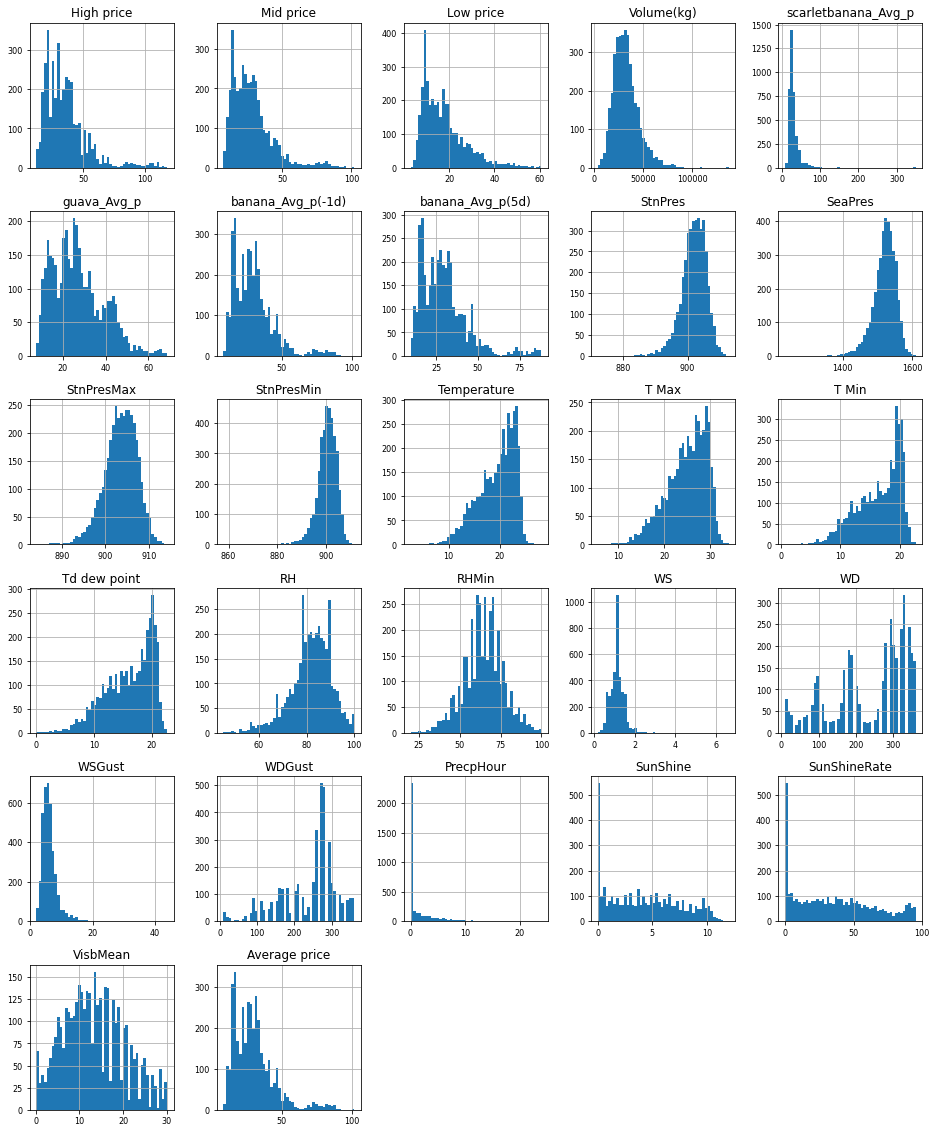

In [147]:
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

In [148]:
df_num_corr = df_num.corr()["Average price"][:-1]
df_num_corr
golden_features_list = df_num_corr[abs(df_num_corr) > 0.3].sort_values(ascending=False)
golden_features_list

banana_Avg_p(5d)       0.994256
banana_Avg_p(-1d)      0.992499
High price             0.991878
Mid price              0.987450
Low price              0.933741
scarletbanana_Avg_p    0.764350
guava_Avg_p            0.421073
StnPresMax             0.326155
StnPres                0.309694
T Max                 -0.303373
T Min                 -0.337118
Td dew point          -0.337585
Temperature           -0.337669
Volume(kg)            -0.364104
Name: Average price, dtype: float64

#### 相關係數（Correlation）

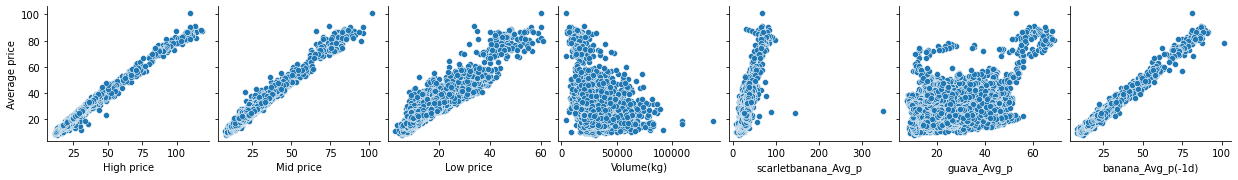

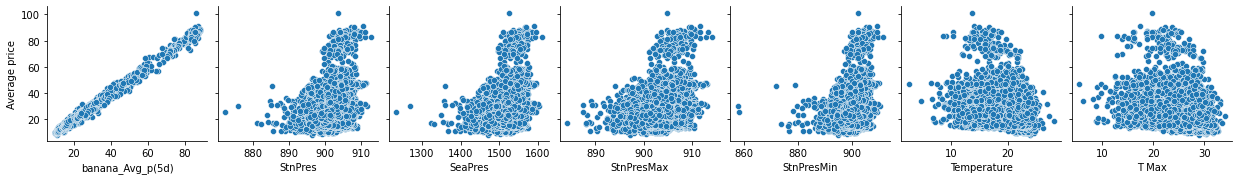

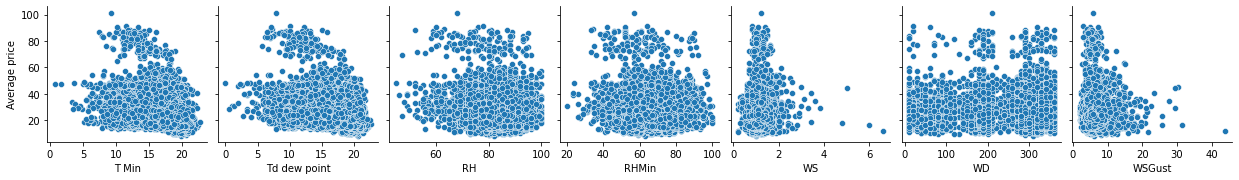

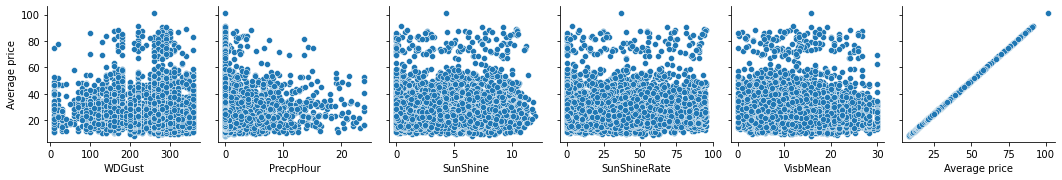

In [165]:
for i in range(0, len(df_num.columns), 7):
    sns.pairplot(data = df_num, diag_kind= None,
                 x_vars = df_num.columns[i:i+7],
                 y_vars = 'Average price')

### Feature to feature relationship

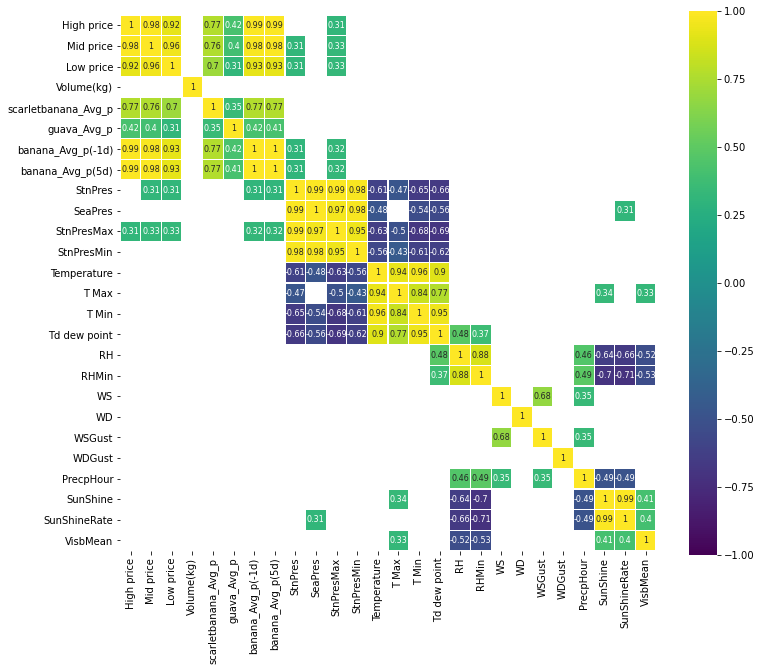

In [154]:
corr = df_num.drop('Average price', axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.4)],
cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
annot=True, annot_kws={"size": 8}, square=True);

In [167]:
username = 'root'
password = 'yuting1101'
host_port = 'localhost:3306' 
database = 'TWfruits'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [168]:
pd.read_sql("banana_台中市", con)

,日期,banana_平均價,banana_交易量,scarletbanana_平均價,guava_平均價,banana_前日平均價,banana_5日平均價
0,2011-01-01,22.1,23713.0,29.7,33.7,22.1,23.1
1,2011-01-02,21.7,27072.0,27.5,36.1,22.1,23.1
2,2011-01-03,23.3,47428.5,32.3,36.1,21.7,23.1
3,2011-01-04,24.9,67785.0,37.1,36.1,23.3,23.1
4,2011-01-05,23.6,34038.0,41.2,35.6,24.9,23.1
...,...,...,...,...,...,...,...
3868,2021-08-04,30.9,23041.0,30.8,19.7,30.3,30.1
3869,2021-08-05,31.8,22484.0,25.6,18.1,30.9,30.8
3870,2021-08-06,30.4,28395.0,32.7,19.4,31.8,30.8
3871,2021-08-07,31.9,20433.0,24.0,20.6,30.4,31.1
